In [2]:
"""
Training EfficientNet-B0 models.
NOTE: in order to be able to save the models, TensorFlow must be downgraded to V2.9.1

Authors: Paul Rosero & Booy Faassen
"""

import tensorflow as tf
from tensorflow import keras
from keras_flops import get_flops
import matplotlib.pyplot as plt
from datetime import datetime
from tensorflow.keras.applications import EfficientNetB0
import psutil
import os

In [5]:
#Define some parameters for the loader:
batch_size = 32
img_height = 224
img_width = 224
root_dir = './data'
class_names=["0.0", "1.0"]

In [6]:
""" Loading the data """

def split_train_test_set(dataset):
    train_dir=root_dir +"/" + dataset +"/" + "train"
    test_dir=root_dir + "/" + dataset +"/" + "test"
    # Import data from directories and turn it into batches
    train_data = tf.keras.preprocessing.image_dataset_from_directory(train_dir,
                                                                     labels='inferred',
                                                                     seed=123,
                                                                     label_mode="categorical",
                                                                     color_mode='rgb',
                                                                     batch_size=batch_size, 
                                                                     image_size=(img_height, img_width)
                                                                    )

    test_data = tf.keras.preprocessing.image_dataset_from_directory(test_dir,
                                                                    labels='inferred',
                                                                    seed=123,
                                                                    label_mode="categorical",
                                                                    color_mode='rgb',
                                                                    batch_size=batch_size, 
                                                                    image_size=(img_height, img_width) 
                                                                   )
    return train_data, test_data

In [7]:
img_augmentation = tf.keras.models.Sequential(
    [
        tf.keras.layers.RandomRotation(factor=0.15),
        tf.keras.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
        tf.keras.layers.RandomFlip(),
        tf.keras.layers.RandomContrast(factor=0.1),
    ],
    name="img_augmentation",
)

In [9]:
""" Set metrics for later use """

METRICS = [
    tf.keras.metrics.Accuracy(name='acc'),
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'), 
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

In [10]:
""" Building the model """

def build_model(num_classes, aprov_pre=False, metrics=METRICS):
    inputs = tf.keras.layers.Input(shape=(img_height,img_width,3))
    if aprov_pre==True: # Applies data augmentation & pre-processing
        x = img_augmentation(inputs)
        model = EfficientNetB0(include_top=False, input_tensor=x, weights="imagenet")
        print("Augmentation:",aprov_pre)
    else: # No data augmentation & pre-processing
        model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")
        print("Augmentation:",aprov_pre)
    # Freeze the pretrained weights
    model.trainable = False

    # print(model.trainable_weights) should return [] after setting model.trainable = False
    
    # Rebuild top
    x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(model.output)
    x = tf.keras.layers.BatchNormalization()(x)

    top_dropout_rate = 0.2
    x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
    outputs = tf.keras.layers.Dense(num_classes, activation="softmax", name="pred")(x)

    # Compile
    model = tf.keras.Model(inputs, outputs, name="EfficientNet")
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2) # 0.01
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics
    )
    return model

In [14]:
""" Plotting """

def plot_hist(hist):
    plt.plot(hist.history["accuracy"])
    plt.plot(hist.history["val_accuracy"])
    plt.title("model accuracy")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train", "validation"], loc="upper left")
    plt.show()

In [15]:
""" Unfreezing layers """

def unfreeze_model(model, num, metrics=METRICS):
    # We unfreeze the top num layers while leaving BatchNorm layers frozen
    for layer in model.layers[num:]:
        if not isinstance(layer, tf.keras.layers.BatchNormalization):
            layer.trainable = True
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-2)
    model.compile(
        optimizer=optimizer, loss="categorical_crossentropy", metrics=metrics
    )

In [16]:
def compare_historys(original_history, new_history, initial_epochs=5):
    """
    Compares two model history objects.
    """
    # Get original history measurements
    acc = original_history.history["accuracy"]
    loss = original_history.history["loss"]

    print(len(acc))

    val_acc = original_history.history["val_accuracy"]
    val_loss = original_history.history["val_loss"]

    # Combine original history with new history
    total_acc = acc + new_history.history["accuracy"]
    total_loss = loss + new_history.history["loss"]

    total_val_acc = val_acc + new_history.history["val_accuracy"]
    total_val_loss = val_loss + new_history.history["val_loss"]

    print(len(total_acc))
    print(total_acc)

    # Make plots
    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(total_acc, label='Training Accuracy')
    plt.plot(total_val_acc, label='Validation Accuracy')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(total_loss, label='Training Loss')
    plt.plot(total_val_loss, label='Validation Loss')
    plt.plot([initial_epochs-1, initial_epochs-1],
              plt.ylim(), label='Start Fine Tuning') # reshift plot around epochs
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [11]:
""" Initializing datasets and number of epochs """

datasets=["dataset01"] # add more by seperating with commas
epochs_vector=[1]

Found 1969 files belonging to 2 classes.
Found 655 files belonging to 2 classes.
preprocessing: False
62/62 [==============================] - 88s 1s/step - loss: 0.9691 - accuracy: 0.7649 - val_loss: 1.0031 - val_accuracy: 0.7000
Instructions for updating:
Use `tf.compat.v1.graph_util.tensor_shape_from_node_def_name`
----------------- MODEL----------------------------
Dataset: dataset01 Epochs: 1
CPU utilization:  28.5
The time of execution of above program is : 0:01:29.512707ms
Total: 0.70%
Individual CPUs: 0.80%  1.60%  0.00%  0.00%  1.60%  0.00%  1.60%  0.00%
RAM memory % used: 89.3
RAM Used (GB): 7.378354176
RAM active (GB): 0.8882176
FLOPS: 25.6 G
---------------------------------------------------


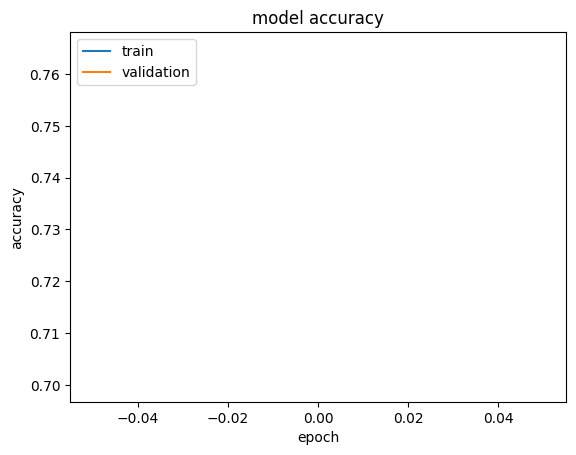

In [12]:
######################## TRANSFER LEARNING MODEL WHITOUT DATA AUGMENTATION ################################
for j in datasets:
    train_data,test_data=split_train_test_set(j)
    for i in epochs_vector:
        model = build_model(num_classes=2,aprov_pre=False)
        start=datetime.now() 
        start_cpu=psutil.cpu_percent(interval=1)
        hist_m = model.fit(train_data,
                    epochs=i,
                    steps_per_epoch=len(train_data),
                    validation_data=test_data,
                    # Go through less of the validation data so epochs are faster (we want faster experiments!)
                    validation_steps=int(0.25 * len(test_data)),
                    verbose=1 )
        end=datetime.now()
        end_cpu=psutil.cpu_percent(interval=None)
        # find difference loop start and end time and display
        td= (end-start)
        td_cpu=(end_cpu-start_cpu)
        flops = get_flops(model, batch_size=batch_size)
        print("----------------- MODEL----------------------------")
        print("Dataset:",j,"Epochs:",i)
        print("CPU utilization: ", td_cpu)
        print(f"The time of execution of above program is : {td}ms")
        # Calling psutil.cpu_precent()for 4 seconds
        cpu_percent_cores = psutil.cpu_percent(interval=2, percpu=True)
        avg = sum(cpu_percent_cores)/len(cpu_percent_cores)
        cpu_percent_total_str = ('%.2f' % avg) + '%'
        cpu_percent_cores_str = [('%.2f' % x) + '%' for x in cpu_percent_cores]
        print('Total: {}'.format(cpu_percent_total_str))
        print('Individual CPUs: {}'.format('  '.join(cpu_percent_cores_str)))
        # Getting % usage of virtual_memory ( 3rd field)
        print('RAM memory % used:', psutil.virtual_memory()[2])
        # Getting usage of virtual_memory in GB ( 4th field)
        print('RAM Used (GB):',psutil.virtual_memory()[3]/1000000000)
        print('RAM active (GB):',psutil.virtual_memory()[4]/1000000000)
        print(f"FLOPS: {flops / 10 ** 9:.03} G")
        print("---------------------------------------------------")
        plot_hist(hist_m)

In [23]:
""" This method of saving saves the whole TensorFlow program, not only the weights during training """

tf.saved_model.save(model, './data/saved_models/EfficientNet_01')

INFO:tensorflow:Assets written to: ./data/saved_models/EfficientNet_01\assets


INFO:tensorflow:Assets written to: ./data/saved_models/EfficientNet_01\assets


In [24]:
""" load model """

loaded_model = tf.saved_model.load('./data/saved_models/EfficientNet_01')